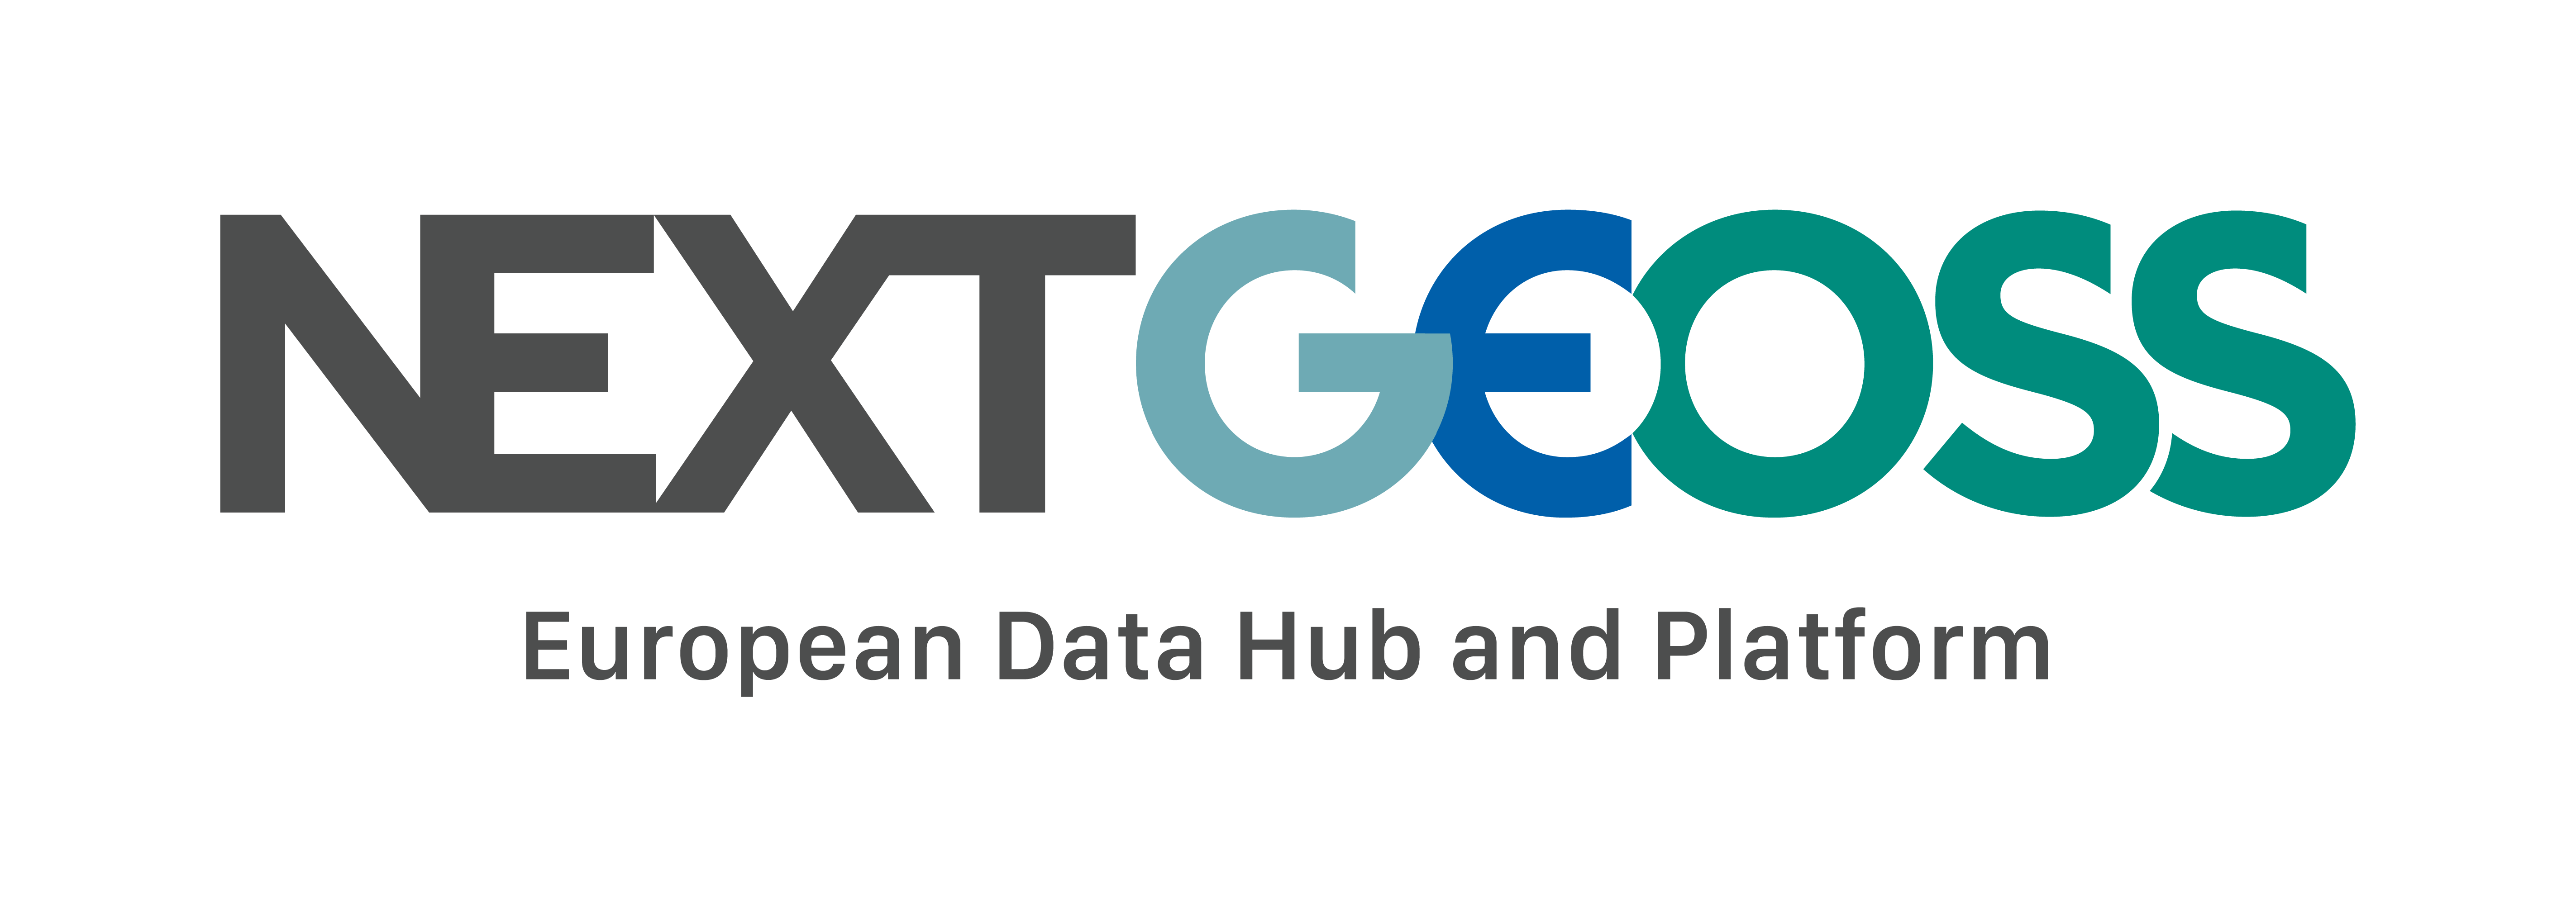

In [1]:
from IPython.display import Image
from IPython.core.display import HTML 

PATH = "./img/"
Image(filename = PATH + "NextGEOSS-Logo.png", width=512, height=256)

# Introduction to NextGEOSS Energy Pilot

 ## Acces time series of gridded data from CAMS Radiation

### This pilot allows to requests for time-series of solar radiation over a regular grid of points covering your area of interest (AOI).

#### GEOGRAPHICAL AREA

Geographical coverage of the CAMS radiation product is the field-of-view of the Meteosat satellite, roughly speaking Europe, Africa, Atlantic Ocean, Middle East (-66° to 66° in both latitudes and longitudes).

#### DATA

The data you request come from CAMS (Copernicus Atmosphere Monitoring Service) Radiation product from a two year time period including the following parameters (Atmosphere optical properties, Ground reflectance, Cloud optical properties, Atmosphere radiative transfer). **#IMPORTANT NOTE: ONLY THE YEARS 2005 AND 2006 ARE AVAILABLE FOR THIS PILOT#**

#### HOW TO REQUEST THE DATA

The resquest to the data is made using an OGC (Open Geospatial COnsortium) standard Web service called WPS (Web Processing Service). This WPS is located remotely on a cloud server and provided as an asynchronous request to the CAMS Radiation process in order to provide you with time series of gridded data on your AOI.

The parameters of the request are first encoded in an url. 

To access the requested data, one must follow a chain of links:
* the first request will return a link to a file that indicates the status of the request (the data being prepared on the server side)
* once the status reach 100%, the same file links to another file
* that files gives the final url that allow one to downloat the data

This notebook will first demonstrate how to build the first url. It will then provide a set of command that fully automate the subsequent "treaure hunt" up to the downloading of the data.

**Please allow some time for data to be processed and donwloaded. When done you'll have a preview of your time series of gridded data at the bottom of the page. The following example retrieve a full day every 15 mn. from 00:15 providing you with 96 layers over an AOI covering France**

# Needed libraries:


The following libraries are used in this notebook:
* re and to build the urls [required]
* urllib3 to download the data directly from the notebook (pip install urllib3[socks]) [required]
* h5py to import result [optional]
* matplotlib for plotting [optional]

If you don't want to use either of the optional library, simply comment out the corresponding import line in the following cell.

In [2]:
import re, time

from urllib3.contrib.socks import SOCKSProxyManager
from urllib3 import PoolManager

import h5py
import matplotlib.pyplot as plt
%matplotlib inline

# Encoding the request in a url:


The first url is the only wat you need to worry about, as it is where you define the particulars of your request (inputs, methods, outputs etc). 

**Url decomposition**
The url can be decomposed in 4 parts:
* The 'base string' defines the requested service:

In [3]:
base_str =  'http://gridded-data.armines.nextgeoss.terradue.com/wps/WebProcessingService?service=wps&version=1.0.0&request=Execute&identifier=com.terradue.wps_oozie.process.OozieAbstractAlgorithm&'

* The inputs string sets the parameters of the request:

In [4]:
input_str = 'dataInputs=bbox=-5.0,46.0,6.0,45.0;width=300;height=300;datex=2453385.510416666666;dt=0.010441666666;count=96;min_tile_width=100;min_tile_height=100;&'

* The output string:

In [5]:
output_str = 'ResponseDocument=result_distribution@mimeType=application/xml;result_osd@mimeType=application/xml&storeExecuteResponse=true&status=true'

The final url is the aggregation of the 4 parts:

In [6]:
url_request = base_str+input_str+output_str
print(url_request)

http://gridded-data.armines.nextgeoss.terradue.com/wps/WebProcessingService?service=wps&version=1.0.0&request=Execute&identifier=com.terradue.wps_oozie.process.OozieAbstractAlgorithm&dataInputs=bbox=-5.0,46.0,6.0,45.0;width=300;height=300;datex=2453385.510416666666;dt=0.010441666666;count=96;min_tile_width=100;min_tile_height=100;&ResponseDocument=result_distribution@mimeType=application/xml;result_osd@mimeType=application/xml&storeExecuteResponse=true&status=true


# Change the input parameters here: !!!


While it is possible to manually modify the url, simple python functions can make wps more flexible. 
The input parameters can be specified by changing the value in <font color='green'>green</font>. In the default example we've selected an AOI (Area Of Interest) covering France with a 300x300 resolution for one day (aturday 2005 Jan) starting at 00:15h every 15 minutes resulting in HDF file of 96 layers This includes:
* **lon_min** (Left side of a bounding box longitude wise in degree - default is -5.5)
* **lat_max** (Right side of a bounding box latitude wise in degree - default is 51.3)
* **lon_max** (Right side of a bounding box longiture wise in degree - default is 8.5)
* **lat_min** (Left side of a bounding box latitude wise in degree - default is 41.0)
* **width** (Size in pixel of the width of the result map - default is 300)
* **height** (Size in pixel of the height of the result map - default is 300)
* **count** (Number of occurence in the time serie of gridded data - default is 96 (Covers 1 day every 15 mn))
* **datex** (Begin date in Julian date - default is Saturday 2005 Jan 15	00:15)
* **dt** (Time span for the number of occurence in Julian time - default is 15 mn)

In [3]:
lon_min=-5.5
lat_max=51.3
lon_max=8.5
lat_min=41.0
width=300
height=300
count=96
datex=2453385.510416666666
dt=0.010441666666

In [8]:
input_str = 'dataInputs=bbox={lon_min:.1f},{lat_max:.1f},{lon_max:.1f},{lat_min:.1f};width={width:d};height={height:d};datex={datex:.12f};dt={dt:.12f};count={count:d};min_tile_width=100;min_tile_height=100;&'
input_str = input_str.format(lon_min=lon_min,lat_max=lat_max,lon_max=lon_max,lat_min=lat_min,width=width,height=height,count=count,datex=datex,dt=dt)
print(input_str)

dataInputs=bbox=-5.5,51.3,8.5,41.0;width=300;height=300;datex=2453385.510416666511;dt=0.010441666666;count=96;min_tile_width=100;min_tile_height=100;&


In [9]:
url_request = base_str+input_str+output_str
print(url_request)

http://gridded-data.armines.nextgeoss.terradue.com/wps/WebProcessingService?service=wps&version=1.0.0&request=Execute&identifier=com.terradue.wps_oozie.process.OozieAbstractAlgorithm&dataInputs=bbox=-5.5,51.3,8.5,41.0;width=300;height=300;datex=2453385.510416666511;dt=0.010441666666;count=96;min_tile_width=100;min_tile_height=100;&ResponseDocument=result_distribution@mimeType=application/xml;result_osd@mimeType=application/xml&storeExecuteResponse=true&status=true


#  Parsing the query and request access to the data:

Several steps are necessary to download the data. While they may seem somewhat cumbersome, once you have encoded your request in url_request you can simply run the following code.

## Get 1st file and extract info
### Warning: this line launches a request. It should not be called several time !

In [10]:
# Warning: this line launches a request. It should not be called several time
r = PoolManager().request('GET', url_request)

In [11]:
xml = r.data.decode('utf-8')
for line in xml.split('\n'):
        if re.search('statusLocation="http.*?"',line):
            my_url_1 = re.sub('.*\n.*statusLocation="(.*?)".*','\\1',xml)

In [12]:
my_url_1

'http://gridded-data.armines.nextgeoss.terradue.com/wps/RetrieveResultServlet?id=f6f1ed91-bd23-437c-b693-0d1d57480536'

## Get 2nd file and extract info

In [13]:
my_match = None
my_url_2 = ''
while not my_match:
    r = PoolManager().request('GET', my_url_1)
    xml = r.data.decode('utf-8')
    for line in xml.split('\n'):
        if re.search('Reference href="http.*?results.metalink"',line):
            my_url_2 = re.sub('.*Reference href="(.*?results.metalink)".*','\\1',xml)
            my_match = True
            break
    if not my_match:
        time.sleep(10)

In [14]:
my_url_2

'http://gridded-data.armines.nextgeoss.terradue.com/data/run/mccloud_map_wps/0000030-181001000009300-oozie-oozi-W/results.metalink'

## Get 3rd file and extract info

In [15]:
final_url = ''
r = PoolManager().request('GET', my_url_2)
xml = r.data.decode('utf-8')
final_url = ''
for line in xml.split('\n'):
    if re.search('<url>(http.*?)</url>',line):
        final_url = re.sub('.*.*<url>(http.*?)</url>.*','\\1',line)
        break


In [16]:
final_url

'http://gridded-data.armines.nextgeoss.terradue.com/data/run/mccloud_map_wps/0000030-181001000009300-oozie-oozi-W/_results/result.h5'

## Download final data:

In [17]:
r = PoolManager().request('GET', final_url)

with open("my_data.h5", "wb") as f:
    content = r.data
    f.write(content)

In [5]:
my_data = h5py.File('my_data.h5', 'r')



# Data visualization with cartopy and ipywidget

To interecatively visualize the data we have improted, we use cartopy and widget. These two libary can be installed on your local machine with the folowing commands:
1. conda install nodejs
2. jupyter labextension install @jupyter-widgets/jupyterlab-manager@0.34
3. conda install -c conda-forge ipywidgets

We will also need numpy and cartopy:
* conda install cartopy
* conda isntall numpy

In [6]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.feature import NaturalEarthFeature, COLORS
from IPython.display import display
import numpy as np
import ipywidgets as widgets 


In [7]:
# Define cartopy features:
resolution = "50m"
BORDERS = NaturalEarthFeature('cultural', 'admin_0_boundary_lines_land',
                              resolution, edgecolor='black', facecolor='none')
STATES = NaturalEarthFeature('cultural', 'admin_1_states_provinces_lakes',
                             resolution, edgecolor='black', facecolor='none')
COASTLINE = NaturalEarthFeature('physical', 'coastline', resolution,
                                edgecolor='black', facecolor='none')
LAKES = NaturalEarthFeature('physical', 'lakes', resolution,
                            edgecolor='face',
                            facecolor=COLORS['water'])
LAND = NaturalEarthFeature('physical', 'land', resolution,
                           edgecolor='face',
                           facecolor=COLORS['land'], zorder=-1)
OCEAN = NaturalEarthFeature('physical', 'ocean', resolution,
                            edgecolor='face',
                            facecolor=COLORS['water'], zorder=-1)
RIVERS = NaturalEarthFeature('physical', 'rivers_lake_centerlines', resolution,
                             edgecolor=COLORS['water'],
                             facecolor='none')

In [8]:
def plot(varname='', time=0):
    # Import variable from data file:
    variable = np.array(my_data[varname][:])
    
    # Prepare figure
    fig = plt.figure(figsize=(14, 12))
    ax = fig.add_subplot(111, projection=ccrs.PlateCarree())
    ax.set_extent([lon_min, lon_max, lat_min, lat_max]) # ToDo: automate coordinates
    ax.set_title(varname, size=16)
    
    # Add country boundaries to plot
    ax.add_feature(BORDERS)
    ax.add_feature(LAKES)
    ax.add_feature(LAND)
    ax.add_feature(OCEAN)
    ax.add_feature(RIVERS)
    ax.add_feature(COASTLINE)

    # Contour based on variable chosen
    c = ax.imshow(variable[time], origin='lower', transform=ccrs.PlateCarree(), extent=[lon_min, lon_max, lat_min, lat_max])
    cb = fig.colorbar(c, ax=ax, shrink=0.7)
    
    cb.set_label(r'$W/m^{2}$', size='large')


In [9]:
# Display results:

var_widget = widgets.Dropdown(
    options={'G': 'G',
             'B': 'B',
             'Gc': 'Gc',
             'Bc': 'Bc'},
    description='Variable', alignment='center')

time_widget = widgets.SelectionSlider(description='Time', options=list(range(96)), width='40%')

play = widgets.Play(
    #interval=10,
    value=0,
    min=0,
    max=count-1,
    step=1,
    description="Press play",
    disabled=False
)

widgets.link((play, 'value'), (time_widget, 'value'))
mybox = widgets.Box([play, time_widget])

x = widgets.interactive(plot, varname=var_widget, time=play)



In [10]:

display(x.children[0],x.children[2],mybox)



Dropdown(description='Variable', options={'G': 'G', 'B': 'B', 'Gc': 'Gc', 'Bc': 'Bc'}, value='G')

Output()

Box(children=(Play(value=0, description='Press play', max=95), SelectionSlider(description='Time', options=(0,…

# Geo-data analysis

Many usecases require 2D geo-localized irradiance data. In this section we illustrate how to utilize this type of data in two usecases.

## Data preparation
In this notebook, we propose to use the Geopandas library to analyse the data. This library can be install on your machine with anaconda using the following commands:
1. conda install -c conda-forge GDAL
2. conda install -c conda-forge shapely
3. conda install -c conda-forge fiona
4. conda install -c conda-forge pyproj
5. conda install -c conda-forge geopandas

We will aslo use pandas and shapely library:
* conda install pandas
* conda install shapely

Geopandas implements so called GeoDataFrame, that ressemple pandas DataFrames and contain the geolocalization of each pixel. The time series of each pixel are stored in another dataframe, whose column names are the coordinates of each pixel.

In [11]:
import geopandas as gpd
import pandas as pd
from shapely.geometry import Point
from shapely.geometry import Polygon

In [12]:
# To do so, we need the lat/lon of each pixel. 
# Since we are using a lat/lon projection, the lat/lon coordintates are regularly spaced:
my_lat = np.linspace(lat_min,lat_max,height).reshape(height,1)
my_lon = np.linspace(lon_min,lon_max,width).reshape(1,width)

my_lat = np.concatenate([my_lat]*width,axis=1)
my_lon = np.concatenate([my_lon]*height,axis=0)


In [13]:
# We then build a geodataframe containing location information for each pixel on the image:
my_gpd = gpd.GeoDataFrame()
my_gpd['Coordinates'] = list(zip(my_lon.flatten(), my_lat.flatten()))
my_gpd['geometry'] = my_gpd['Coordinates'].apply(Point)
my_gpd.crs = {'init' :'epsg:4326'}
my_gpd.head()


,Coordinates,geometry
0,"(-5.5, 41.0)",POINT (-5.5 41)
1,"(-5.45317725753, 41.0)",POINT (-5.453177257525083 41)
2,"(-5.40635451505, 41.0)",POINT (-5.406354515050167 41)
3,"(-5.35953177258, 41.0)",POINT (-5.35953177257525 41)
4,"(-5.3127090301, 41.0)",POINT (-5.312709030100335 41)


In [14]:
# A (regular, pandas) DataFrame is then build. 
# Each column corresponds to one of the pixel referenced in the GeoDataFrame defined previously.
# The column name correponds to the pixel's coordinates.
my_tsdf = pd.DataFrame(my_data['G'][:].reshape(count,width*height),index=range(count))
my_tsdf.columns=my_gpd.Coordinates
my_tsdf = my_tsdf.fillna(0)

In [15]:
# Example:
my_tsdf.loc[40:45].head()

Coordinates,"(-5.5, 41.0)","(-5.45317725753, 41.0)","(-5.40635451505, 41.0)","(-5.35953177258, 41.0)","(-5.3127090301, 41.0)","(-5.26588628763, 41.0)","(-5.21906354515, 41.0)","(-5.17224080268, 41.0)","(-5.1254180602, 41.0)","(-5.07859531773, 41.0)",...,"(8.07859531773, 51.3)","(8.1254180602, 51.3)","(8.17224080268, 51.3)","(8.21906354515, 51.3)","(8.26588628763, 51.3)","(8.3127090301, 51.3)","(8.35953177258, 51.3)","(8.40635451505, 51.3)","(8.45317725753, 51.3)","(8.5, 51.3)"
40,104.023918,120.430878,98.302910,89.023544,143.394958,126.573769,150.826416,111.197548,124.433487,128.191360,...,428.683563,408.044250,372.897003,395.081970,431.602783,431.070923,431.502686,431.974182,431.460663,427.801727
41,147.361298,134.733780,131.399429,135.329330,101.954857,101.626854,168.976959,120.547890,167.662094,169.490463,...,427.917603,426.240387,402.320679,437.704407,449.374390,448.781464,449.189392,449.638367,450.086975,450.535156
42,164.165710,113.024719,176.675095,149.061523,153.184738,162.270432,170.869263,142.252701,121.510735,120.251923,...,456.314362,457.487579,454.153595,461.718018,463.607666,462.959595,463.341858,463.766174,464.190125,464.613678
43,160.929794,188.552277,185.479782,198.487549,151.617996,168.787674,189.671112,163.480957,162.581924,159.990479,...,471.497803,471.893524,472.288940,472.683990,474.214630,473.517761,473.872772,474.270599,474.668060,475.065155
44,193.149155,188.295807,204.048050,213.310196,212.448868,155.842789,216.207718,117.718117,158.961609,216.147751,...,478.513092,478.880554,479.247742,479.614624,481.131561,480.392517,0.000000,0.000000,481.458221,481.827332


In [16]:
# The following function allows the retrieval of a single time stamp over the whole area
my_geom = my_gpd.geometry
def get_frame_df(t):
    plot_gpd = gpd.GeoDataFrame(my_tsdf.loc[t].transpose())
    plot_gpd.columns = ['G']
    plot_gpd = plot_gpd.reset_index()
    plot_gpd['geometry'] = my_geom
    return(plot_gpd)


In [17]:
import os
os.getcwd()

'/Users/hadrien/Dropbox/Documents/Collaborations/LionelMenard/armines-cams-gridded-data'

In [18]:
# Geopanads allows us to combine data from several sources. For example we may want to incorporate France adminstrative border into the plot:
laFrance = gpd.read_file('GeoData/DEPARTEMENT_METROPOLE.geojson')
laFrance = laFrance.to_crs({'init' :'epsg:4326'})
laFrance.head()

,ID_GEOFLA,CODE_DEPT,NOM_DEPT,CODE_CHF,NOM_CHF,X_CHF_LIEU,Y_CHF_LIEU,X_CENTROID,Y_CENTROID,CODE_REG,NOM_REG,geometry
0,DEPARTEM0000000000000001,39,JURA,300,LONS-LE-SAUNIER,895198,6622537,886172,6641548,27,BOURGOGNE-FRANCHE-COMTE,(POLYGON ((5.444410590616399 46.84534115162455...
1,DEPARTEM0000000000000002,42,LOIRE,218,SAINT-ETIENNE,808646,6482549,795655,6521581,84,AUVERGNE-RHONE-ALPES,"(POLYGON ((3.831740353926586 45.9994428066684,..."
2,DEPARTEM0000000000000003,76,SEINE-MARITIME,540,ROUEN,562355,6928721,550942,6952842,28,NORMANDIE,(POLYGON ((0.3871470776027273 49.7718770351546...
3,DEPARTEM0000000000000004,89,YONNE,024,AUXERRE,742447,6744261,748211,6750855,27,BOURGOGNE-FRANCHE-COMTE,(POLYGON ((3.126677387392826 47.99126841691494...
4,DEPARTEM0000000000000005,68,HAUT-RHIN,066,COLMAR,1024125,6784581,1016174,6763894,44,ALSACE-CHAMPAGNE-ARDENNE-LORRAINE,"(POLYGON ((6.9238240349725 47.95247126466695, ..."


## Usecase 1: resources in a department vs a point

In [19]:
# Extract the shape of Herault from file:
my_dpt = laFrance[laFrance.NOM_DEPT=='HERAULT']

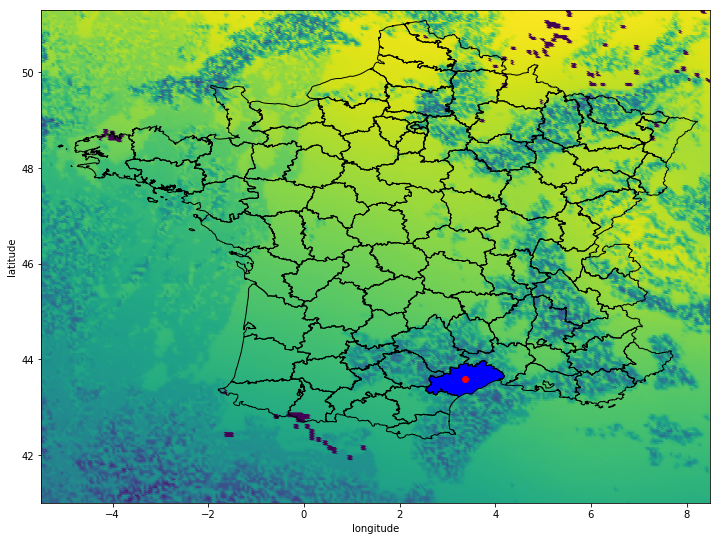

In [21]:
# Plot shape on top of our data:
## We use our data as base for our plot:
frame_to_plot = get_frame_df(45)
base = frame_to_plot.plot( column='G',figsize=(12,12))
base.set_xlabel("longitude")
base.set_ylabel("latitude")

## Add French borders to the plot:
laFrance.boundary.plot(ax=base,color='black',lw=1)
base.set_ylim(lat_min, lat_max)
base.set_xlim(lon_min, lon_max)

## Plot department and its center
my_dpt.plot(ax=base,color='blue',lw=2)
my_dpt.centroid.plot(ax=base,color='red')

In [22]:
# Resource for Herault:
my_intersection = my_gpd.within(my_dpt.geometry.iloc[0])
herault_ts = my_tsdf.loc[:,my_gpd[my_intersection].Coordinates].mean(axis=1)

# Resource for its center:
distance = my_gpd.geometry.apply(lambda x: my_dpt.centroid.distance(x))
nearest_pt = my_gpd.iloc[distance.idxmin()]
center_ts = my_tsdf[nearest_pt.Coordinates.iloc[0]]



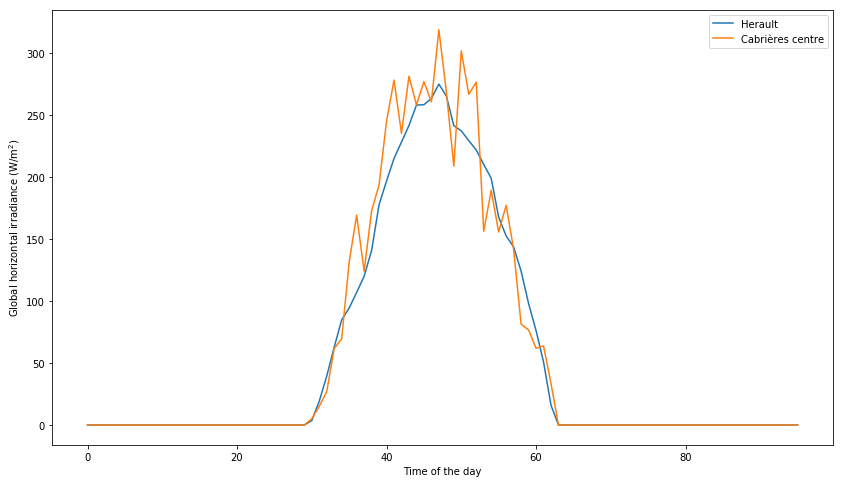

In [23]:
plt.figure(figsize=(14,8))
plt.plot(herault_ts,label='Herault')
plt.plot(center_ts,label='Cabrières centre')
plt.xlabel('Time of the day')
plt.ylabel('Global horizontal irradiance (W/m$^2$)')
plt.legend()

## Usecase 2: resources in a zone vs a point


In [24]:
# Define shape:
p1 = Polygon([(3.7,43.4),(4,43.4),(4,43.8),(3.7,43.8)])
myPol = gpd.GeoSeries(p1)
myPol.crs = {'init' :'epsg:4326'}

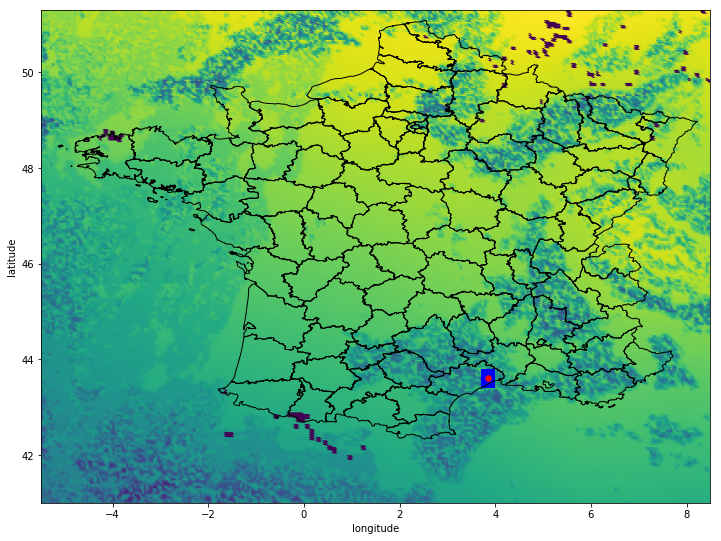

In [25]:
# Plot shape on top of our data:
## We use our data as base for our plot:
frame_to_plot = get_frame_df(45)
base = frame_to_plot.plot( column='G',figsize=(12,12))
base.set_xlabel("longitude")
base.set_ylabel("latitude")

## Add French borders to the plot:
laFrance.boundary.plot(ax=base,color='black',lw=1)
base.set_ylim(lat_min, lat_max)
base.set_xlim(lon_min, lon_max)

## Plot our polygon and its center
myPol.plot(ax=base,color='blue')
myPol.centroid.plot(ax=base,color='red',lw=.5)

In [26]:
# Resource for Zone:
my_intersection = my_gpd.within(myPol.geometry.iloc[0])
zone_ts = my_tsdf.loc[:,my_gpd[my_intersection].Coordinates].mean(axis=1)
my_tsdf.loc[:,my_gpd[my_intersection].Coordinates].mean(axis=1).iloc[45:55]

# Resource for its center:
distance = my_gpd.geometry.apply(lambda x: myPol.distance(x))
nearest_pt = my_gpd.iloc[distance.idxmin()]
center_ts = my_tsdf[nearest_pt.Coordinates.iloc[0]]


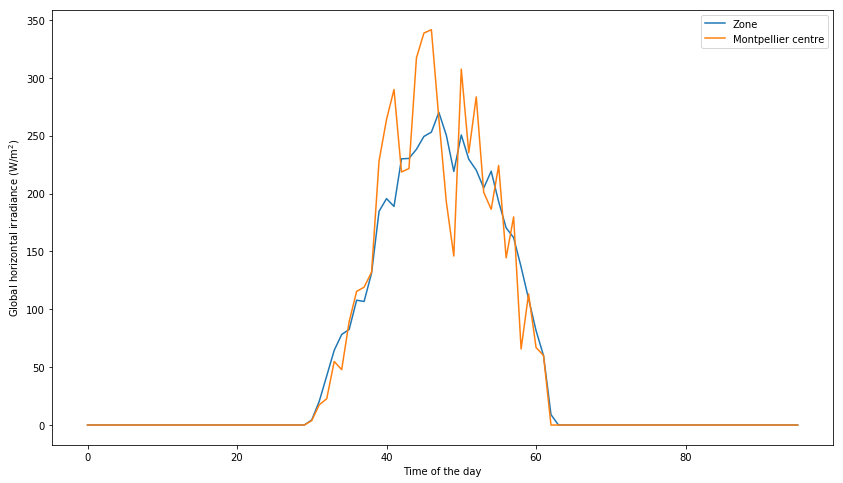

In [27]:
# Compare resources
plt.figure(figsize=(14,8))
plt.plot(zone_ts,label='Zone')
plt.plot(center_ts,label='Montpellier centre')
plt.xlabel('Time of the day')
plt.ylabel('Global horizontal irradiance (W/m$^2$)')
plt.legend()
